In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

**Меня в основном интересует задача регрессии, поэтому я буду оставлять только не шумовые ивенты в некоторых частях кода.**

In [27]:
from tqdm import tqdm_notebook

In [2]:
DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
lpmt_hits = pd.read_hdf(DATA_DIR + 'train/train_lpmt_hits.h5', mode='r') 

In [3]:
spmt_hits = pd.read_hdf(DATA_DIR + 'train/train_spmt_hits.h5', mode='r')
lpmt_pos = pd.read_csv(DATA_DIR + 'train/lpmt_pos.csv') 
spmt_pos = pd.read_csv(DATA_DIR + 'train/spmt_pos.csv') 

In [4]:
train_info = pd.read_csv(DATA_DIR + 'train/train_info.csv')

In [11]:
lpmt_energy = lpmt_hits.merge(train_info, left_on='event', right_on='evtID')

In [12]:
lpmt_energy[:4]

,event,hitTime,isDN,pmtID,E,R,evtID,x,y,z
0,0,249.992615,False,14175,4.747791,14610.378,0,8290.779,11995.618,911.74286
1,0,40.010311,False,17319,4.747791,14610.378,0,8290.779,11995.618,911.74286
2,0,162.123199,False,16882,4.747791,14610.378,0,8290.779,11995.618,911.74286
3,0,51.875614,False,14951,4.747791,14610.378,0,8290.779,11995.618,911.74286


In [13]:
lpmt_energy.drop('evtID', axis=1, inplace=True)

In [17]:
lpmt_energy = lpmt_energy[lpmt_energy['isDN'] == False]

**Получим времена начала детектирования каждого события.**

In [9]:
event = lpmt_energy.groupby('event')['hitTime'].min()

In [33]:
import gc
gc.collect()

13927

In [32]:
event = pd.DataFrame(event)

In [38]:
event['event_id'] = event.index

In [40]:
event[:3]

,hitTime,event_id
event,,
0,-97.5732,0
1,-99.279,1
3,-98.6184,3


In [46]:
event.isnull().any()

hitTime     False
event_id    False
dtype: bool

In [55]:
event['event_id'] = event['event_id'].astype(int)

In [56]:
event['hitTime'] = event['hitTime'].astype(float)

In [59]:
event.dtypes

hitTime     float64
event_id      int64
dtype: object

**Получим распределение времен, через которые детекторы детектируют событие по сравнению с первым детектором.**

In [60]:
lpmt_energy = lpmt_energy.merge(event, left_on='event', right_on='event_id')

In [65]:
gc.collect()

7

In [64]:
lpmt_energy.drop('event_id', axis=1, inplace=True)

In [66]:
lpmt_energy[:3]

,event,hitTime_x,isDN,pmtID,E,R,x,y,z,hitTime_y
0,0,249.992615,False,14175,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189
1,0,40.010311,False,17319,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189
2,0,162.123199,False,16882,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189


In [71]:
gc.collect()

1407

In [69]:
time_difference = lpmt_energy['hitTime_x'] - lpmt_energy['hitTime_y']

CPU times: user 2.78 s, sys: 384 ms, total: 3.16 s
Wall time: 1.79 s


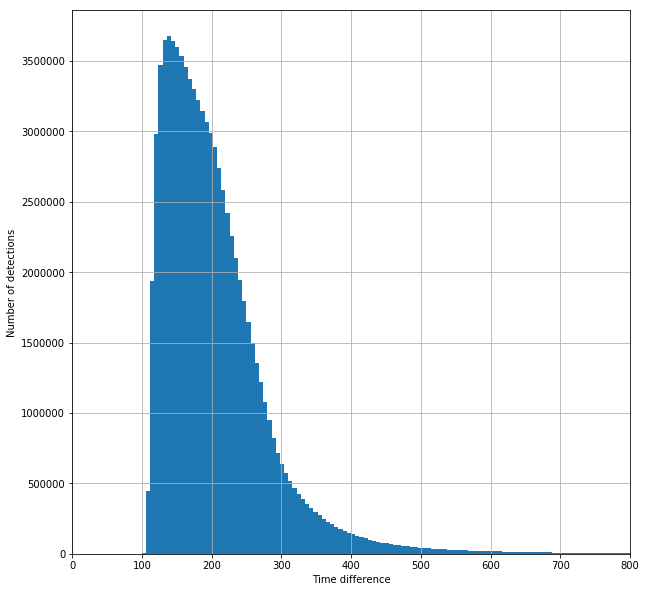

In [81]:
%%time
time_difference.hist(bins=150, figsize=(10,10))
plt.xlabel("Time difference")
plt.ylabel("Number of detections")
plt.xlim(0,800)

**Среди больших детекторов при регистрации, большинство детекторов регистрирует ивент уже с большой задержкой 50-200. Затем идет быстрый экспоненциальный спад. Предположение: начиная с какого-то радиуса (предположительно радиус эффекта Вавилова-Черенкова от конкретного удара) начинается экспоненциальный спад попавших в детектор фотонов. При этом есть определенная небольшая зона, в которую сигнал идет быстрее чем в остальные, чем это обусловленно не понятно. Возможно это как-то связано с чем-то еще.**

**Проверим так же ли обстоят дела в маленьких детекторах**

In [83]:
gc.collect()

30937

In [85]:
spmt_energy = spmt_hits.merge(train_info, left_on='event', right_on='evtID')
spmt_energy.drop('evtID', axis=1, inplace=True)
spmt_energy = spmt_energy[spmt_energy['isDN'] == False]

In [87]:
sevent = pd.DataFrame(spmt_energy.groupby('event')['hitTime'].min())

In [88]:
sevent['event_id'] = sevent.index

In [89]:
sevent.dtypes

hitTime     float32
event_id      int64
dtype: object

In [90]:
spmt_energy = spmt_energy.merge(sevent, left_on='event', right_on='event_id')

In [91]:
spmt_energy.drop('event_id', axis=1, inplace=True)

In [94]:
spmt_energy[:3]

,event,hitTime_x,isDN,pmtID,E,R,x,y,z,hitTime_y
0,0,238.278091,False,311819,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285
1,0,103.316055,False,307244,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285
2,0,108.034225,False,323230,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285


In [92]:
stime_difference = spmt_energy['hitTime_x'] - spmt_energy['hitTime_y']

CPU times: user 540 ms, sys: 4 ms, total: 544 ms
Wall time: 148 ms


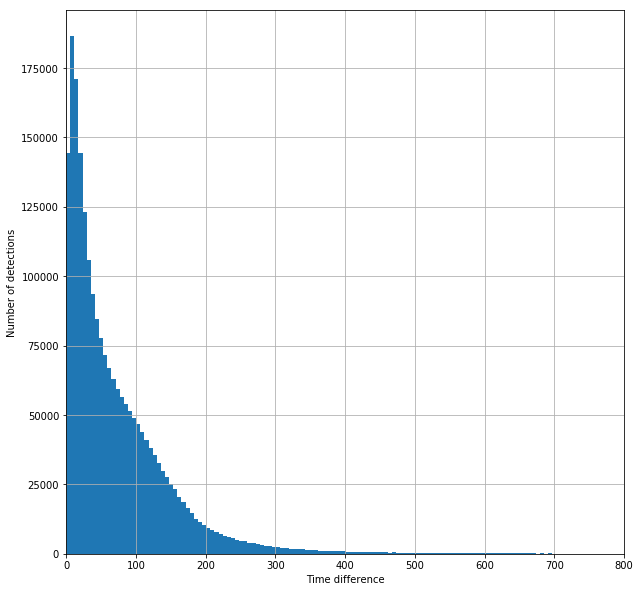

In [93]:
%%time
stime_difference.hist(bins=150, figsize=(10,10))
plt.xlabel("Time difference")
plt.ylabel("Number of detections")
plt.xlim(0,800)

**Как видим у маленьких детекторов все выглядит естественнее. Примерно экспоненциальный спад до разницы в 50, затем линейная полоса почти до 200, а потом опять экспоненциальный спад. Нету области, в которую сигнал доходит быстрее. Интересно почему.**